In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc

data = pd.read_csv('../data/Bcard.txt')
feature_lst = ['person_info','finance_info','credit_info','act_info']
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()

* 代价敏感

In [4]:
x = train[feature_lst]
y = train['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

lr_model = LogisticRegression(C=0.1)
lr_model.fit(x,y)

y_pred = lr_model.predict_proba(x)[:,1] #取出训练集预测值
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred) #计算TPR和FPR
train_ks = abs(fpr_lr_train - tpr_lr_train).max() #计算训练集KS
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1] #计算验证集预测值
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)   #计算验证集预测值
val_ks = abs(fpr_lr - tpr_lr).max()         #计算验证集KS值
print('val_ks : ',val_ks)

train_ks :  0.41573985983413414
val_ks :  0.3928959732014397


In [5]:
#查看样本数量
y.value_counts()


0.0    78361
1.0     1470
Name: bad_ind, dtype: int64

In [6]:
val_y.value_counts()


0.0    15647
1.0      328
Name: bad_ind, dtype: int64

In [7]:
#手动计算权重
import numpy as np
y.shape[0]/(2 * np.bincount(y))

array([ 0.50937967, 27.15340136])

In [8]:
lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)

LogisticRegression(C=0.1, class_weight='balanced')

In [9]:
y_pred = lr_model.predict_proba(x)[:,1] #取出训练集预测值
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred) #计算TPR和FPR
train_ks = abs(fpr_lr_train - tpr_lr_train).max() #计算训练集KS
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1] #计算验证集预测值
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)   #计算验证集预测值
val_ks = abs(fpr_lr - tpr_lr).max()         #计算验证集KS值
print('val_ks : ',val_ks)


train_ks :  0.4482325608488951
val_ks :  0.4198642457760936


* SMOTE

In [10]:
#自定义方法，用于模型训练的
def lgb_test(train_x,train_y,test_x,test_y):
    import lightgbm as lgb
    clf =lgb.LGBMClassifier(boosting_type = 'gbdt',
                            objective = 'binary',
                            metric = 'auc',
                            learning_rate = 0.1,
                            n_estimators = 24,
                            max_depth = 4,
                            num_leaves = 25,
                            max_bin = 40,
                            min_data_in_leaf = 5,
                            bagging_fraction = 0.6,
                            bagging_freq = 0,
                            feature_fraction = 0.8,
                            )
    clf.fit(train_x,train_y,eval_set=[(train_x,train_y),(test_x,test_y)],eval_metric = 'auc')
    return clf,clf.best_score_['valid_1']['auc']

In [11]:
#根据前面内容得知，如下四个列是特征筛选后留下的列，也就是去掉了其他不重要的列
feature_lst = ['person_info','finance_info','credit_info','act_info']

#准备数据
train_x = train[feature_lst]
train_y = train['bad_ind']
test_x = val[feature_lst]
test_y = val['bad_ind']

#调用函数，进行训练
lgb_model,lgb_auc  = lgb_test(train_x,train_y,test_x,test_y)

#模型预测
sample = train_x.copy()
sample['bad_ind'] = train_y
sample['pred'] = lgb_model.predict_proba(train_x)[:,1]
sample

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 1470, number of negative

,person_info,finance_info,credit_info,act_info,bad_ind,pred
0,-0.322581,0.023810,0.00,0.217949,0.0,0.004041
1,-0.128677,0.023810,0.00,0.423077,0.0,0.005477
2,0.062660,0.023810,0.10,0.448718,0.0,0.017776
3,0.078853,0.071429,0.05,0.179487,0.0,0.067900
4,-0.261014,0.023810,0.00,0.423077,0.0,0.004112
...,...,...,...,...,...,...
79826,0.078853,0.071429,0.13,0.076923,0.0,0.061145
79827,0.078853,0.023810,0.00,0.076923,0.0,0.015513
79828,0.078853,0.023810,0.02,0.076923,0.0,0.020286
79829,0.078853,0.023810,0.00,0.076923,0.0,0.015513


In [12]:
#对刚刚预测的结果进行排序，按照pred倒序排序
sample = sample.sort_values(by=['pred'],ascending=False).reset_index()
#使用当前行的index/总的样本数，得到当前行占所有行的比例，这就是排名
sample['rank'] = sample.index.values/len(sample)
sample

,index,person_info,finance_info,credit_info,act_info,bad_ind,pred,rank
0,12039,0.062660,0.690476,0.85,0.076923,1.0,0.608498,0.000000
1,56269,0.078853,0.738095,0.35,0.525641,1.0,0.584865,0.000013
2,79624,0.078853,0.619048,0.86,0.076923,0.0,0.565661,0.000025
3,50459,0.078853,0.571429,0.17,0.153846,1.0,0.562057,0.000038
4,12355,0.078853,0.666667,0.25,0.397436,0.0,0.547170,0.000050
...,...,...,...,...,...,...,...,...
79826,31712,-0.322581,0.023810,0.00,0.551282,0.0,0.003445,0.999937
79827,31717,-0.322581,0.023810,0.00,0.551282,0.0,0.003445,0.999950
79828,31750,-0.322581,0.023810,0.00,0.576923,0.0,0.003445,0.999962
79829,31756,-0.322581,0.023810,0.00,0.538462,0.0,0.003445,0.999975


In [13]:
#数据过滤
#x：真实值
#y：占比
def weight(x, y):
    #真实为0（好人），但是排名靠前（预测为坏人）
    if x == 0 and y < 0.1:
        return 0.1
    #真实为1（坏人），但是排名靠后（预测为好人）
    elif x == 1 and y > 0.7:
        return 0.1
    else:
        return 1
sample['weight'] = sample.apply(lambda row:weight(row['bad_ind'],row['rank']),axis=1)
sample

,index,person_info,finance_info,credit_info,act_info,bad_ind,pred,rank,weight
0,12039,0.062660,0.690476,0.85,0.076923,1.0,0.608498,0.000000,1.0
1,56269,0.078853,0.738095,0.35,0.525641,1.0,0.584865,0.000013,1.0
2,79624,0.078853,0.619048,0.86,0.076923,0.0,0.565661,0.000025,0.1
3,50459,0.078853,0.571429,0.17,0.153846,1.0,0.562057,0.000038,1.0
4,12355,0.078853,0.666667,0.25,0.397436,0.0,0.547170,0.000050,0.1
...,...,...,...,...,...,...,...,...,...
79826,31712,-0.322581,0.023810,0.00,0.551282,0.0,0.003445,0.999937,1.0
79827,31717,-0.322581,0.023810,0.00,0.551282,0.0,0.003445,0.999950,1.0
79828,31750,-0.322581,0.023810,0.00,0.576923,0.0,0.003445,0.999962,1.0
79829,31756,-0.322581,0.023810,0.00,0.538462,0.0,0.003445,0.999975,1.0


In [14]:
#把上述数据中，0.1的过滤掉。留下1的数据
smote_sample = sample[sample['weight'] == 1]
smote_sample

,index,person_info,finance_info,credit_info,act_info,bad_ind,pred,rank,weight
0,12039,0.062660,0.690476,0.85,0.076923,1.0,0.608498,0.000000,1.0
1,56269,0.078853,0.738095,0.35,0.525641,1.0,0.584865,0.000013,1.0
3,50459,0.078853,0.571429,0.17,0.153846,1.0,0.562057,0.000038,1.0
6,14215,0.078853,0.761905,0.18,0.076923,1.0,0.542053,0.000075,1.0
9,76509,0.078853,0.595238,0.20,0.076923,1.0,0.532588,0.000113,1.0
...,...,...,...,...,...,...,...,...,...
79826,31712,-0.322581,0.023810,0.00,0.551282,0.0,0.003445,0.999937,1.0
79827,31717,-0.322581,0.023810,0.00,0.551282,0.0,0.003445,0.999950,1.0
79828,31750,-0.322581,0.023810,0.00,0.576923,0.0,0.003445,0.999962,1.0
79829,31756,-0.322581,0.023810,0.00,0.538462,0.0,0.003445,0.999975,1.0


In [15]:
#准备x和y
train_x_smote = smote_sample[feature_lst]
train_y_smote = smote_sample['bad_ind']
train_x_smote

,person_info,finance_info,credit_info,act_info
0,0.062660,0.690476,0.85,0.076923
1,0.078853,0.738095,0.35,0.525641
3,0.078853,0.571429,0.17,0.153846
6,0.078853,0.761905,0.18,0.076923
9,0.078853,0.595238,0.20,0.076923
...,...,...,...,...
79826,-0.322581,0.023810,0.00,0.551282
79827,-0.322581,0.023810,0.00,0.551282
79828,-0.322581,0.023810,0.00,0.576923
79829,-0.322581,0.023810,0.00,0.538462


In [16]:
from imblearn.over_sampling import SMOTE

#自定义函数，用于SMOTE过采样
def smote(train_x_smote,train_y_smote,K=15,random_state=0):
    #创建SMOTE对象
    smote = SMOTE(k_neighbors=K,n_jobs=1,random_state=random_state)
    #调用方法，实现过采样
    #fit就是找到最近K个邻居的过程，resample就是进行人工合成新样本的过程
    rex, rey = smote.fit_resample(train_x_smote, train_y_smote)
    return rex, rey

In [17]:
#调用自定义函数，实现数据的过采样
rex,rey = smote(train_x_smote,train_y_smote)



In [18]:
#统计少数类样本数量是否增多
train_y_smote.value_counts()


0.0    71112
1.0     1417
Name: bad_ind, dtype: int64

In [19]:
#统计使用smote算法后的样本数量
rey.value_counts()


0.0    71112
1.0    71112
Name: bad_ind, dtype: int64

In [20]:
#这里没有使用代价敏感
lr_model = LogisticRegression(C=0.1)
lr_model.fit(rex[feature_lst],rey)
x = train[feature_lst]
y = train['bad_ind']
val_x =  val[feature_lst]
val_y = val['bad_ind']

y_pred = lr_model.predict_proba(x)[:,1] #取出训练集预测值
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred) #计算TPR和FPR
train_ks = abs(fpr_lr_train - tpr_lr_train).max() #计算训练集KS
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1] #计算验证集预测值
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)   #计算验证集预测值
val_ks = abs(fpr_lr - tpr_lr).max()         #计算验证集KS值
print('val_ks : ',val_ks)


train_ks :  0.4716010854004061
val_ks :  0.42901331510598933


* LOF（是一个基于密度的无监督算法）

In [21]:
from pyod.models.lof import LOF

#创建LOF对象
clf = LOF(n_neighbors=20, algorithm='auto')
#无监督学习算法，因此没有y，不需要传入y
clf.fit(x)

#模型预测
train['out_pred'] = clf.predict_proba(x)[:,1]
train

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info,out_pred
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949,4.106591e-10
1,1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077,4.106591e-10
2,2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718,5.482939e-10
3,3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487,4.018489e-10
4,4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077,4.106591e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79826,79826,2018-09-30,0.0,Ab99_96436392005147255,0.905578,0.927706,0.994447,0.315842,0.959443,0.042640,0.078853,0.071429,0.13,0.076923,1.897533e-02
79827,79827,2018-10-31,0.0,Ab99_96436392005205003,0.639265,0.219267,0.845014,0.751332,0.275557,0.902642,0.078853,0.023810,0.00,0.076923,4.106591e-10
79828,79828,2018-10-31,0.0,Ab99_96436392005412387,0.355061,0.837747,0.931882,0.442463,0.579277,0.740754,0.078853,0.023810,0.02,0.076923,4.106591e-10
79829,79829,2018-10-31,0.0,Ab99_96436392006241624,0.797237,0.501238,0.490850,0.592068,0.479618,0.859870,0.078853,0.023810,0.00,0.076923,4.106591e-10


In [25]:
#随机给的一个93%分数数的一个参考值（93%是随便给的，不宜太小）
#判断依据：只要小于93%分位数的值，就说明这个样本是正常数据，如果大于93%分位数的值，则说明是异常数据
key = train['out_pred'].quantile(0.93)
key

1.2496968650458789e-09

In [28]:
#过滤异常样本
#train[train['out_pred'] < key]
#获取用于模型训练的特征列
x = train[train['out_pred'] < key][feature_lst]
x

,person_info,finance_info,credit_info,act_info
0,-0.322581,0.023810,0.00,0.217949
1,-0.128677,0.023810,0.00,0.423077
2,0.062660,0.023810,0.10,0.448718
3,0.078853,0.071429,0.05,0.179487
4,-0.261014,0.023810,0.00,0.423077
...,...,...,...,...
79825,0.078853,0.023810,0.13,0.076923
79827,0.078853,0.023810,0.00,0.076923
79828,0.078853,0.023810,0.02,0.076923
79829,0.078853,0.023810,0.00,0.076923


In [31]:
y = train[train['out_pred'] < key]['bad_ind']
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
79825    0.0
79827    0.0
79828    0.0
79829    0.0
79830    0.0
Name: bad_ind, Length: 74242, dtype: float64

In [33]:
#准备验证集的x和y
val_x = val[feature_lst]
val_y = val['bad_ind']

In [34]:
#模型训练
lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)

LogisticRegression(C=0.1, class_weight='balanced')

train_ks :  0.44421602352070516
val_ks :  0.41967251573199565


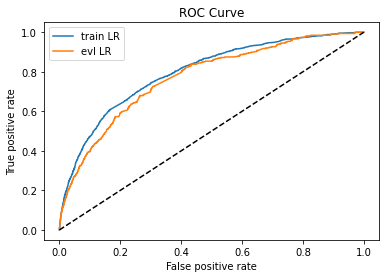

In [35]:
#模型预测和画图
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()


* IF（孤立森林）


train_ks :  0.4482325608488951
val_ks :  0.4198642457760936


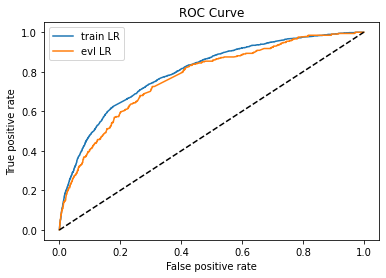

In [36]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc

#数据加载
data = pd.read_csv('../data/Bcard.txt')
data.head()

#数据集划分
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()
feature_lst = ['person_info','finance_info','credit_info','act_info']

x = train[feature_lst]
y = train['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

#模型训练
lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)

#模型预测
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

#画图
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()


In [37]:
from pyod.models.iforest import IForest

#创建IF对象，训练模型
clf = IForest(behaviour='new',n_estimators=500,n_jobs=-1)
clf.fit(x)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=500, n_jobs=-1, random_state=None,
    verbose=0)

In [38]:
#模型预测
out_pred = clf.predict_proba(x,method='linear')[:,1]
out_pred

array([0.09787348, 0.13266869, 0.28901418, ..., 0.02941233, 0.        ,
       0.        ])

In [39]:
train['out_pred'] = out_pred
train

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info,out_pred
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949,0.097873
1,1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077,0.132669
2,2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718,0.289014
3,3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487,0.291097
4,4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077,0.150935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79826,79826,2018-09-30,0.0,Ab99_96436392005147255,0.905578,0.927706,0.994447,0.315842,0.959443,0.042640,0.078853,0.071429,0.13,0.076923,0.258001
79827,79827,2018-10-31,0.0,Ab99_96436392005205003,0.639265,0.219267,0.845014,0.751332,0.275557,0.902642,0.078853,0.023810,0.00,0.076923,0.000000
79828,79828,2018-10-31,0.0,Ab99_96436392005412387,0.355061,0.837747,0.931882,0.442463,0.579277,0.740754,0.078853,0.023810,0.02,0.076923,0.029412
79829,79829,2018-10-31,0.0,Ab99_96436392006241624,0.797237,0.501238,0.490850,0.592068,0.479618,0.859870,0.078853,0.023810,0.00,0.076923,0.000000


In [41]:
#train['out_pred'] < 0.7 是一个经验值。
#这个值越接近0，说明数据越正常
#这个值越接近1，说明数据越异常
#获取数据中的feature_lst列（person_info，finance_info，credit_info，act_info）
x = train[train['out_pred'] < 0.7][feature_lst]
x

,person_info,finance_info,credit_info,act_info
0,-0.322581,0.023810,0.00,0.217949
1,-0.128677,0.023810,0.00,0.423077
2,0.062660,0.023810,0.10,0.448718
3,0.078853,0.071429,0.05,0.179487
4,-0.261014,0.023810,0.00,0.423077
...,...,...,...,...
79826,0.078853,0.071429,0.13,0.076923
79827,0.078853,0.023810,0.00,0.076923
79828,0.078853,0.023810,0.02,0.076923
79829,0.078853,0.023810,0.00,0.076923


In [42]:
y = train[train['out_pred'] < 0.7]['bad_ind']
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
79826    0.0
79827    0.0
79828    0.0
79829    0.0
79830    0.0
Name: bad_ind, Length: 78202, dtype: float64

In [43]:
#准备验证集数据
val_x = val[feature_lst]
val_y = val['bad_ind']


In [44]:
#模型训练
lr_model = LogisticRegression(C=0.1, class_weight='balanced')
lr_model.fit(x,y)


LogisticRegression(C=0.1, class_weight='balanced')

train_ks :  0.42441317344139723
val_ks :  0.42960019609463046


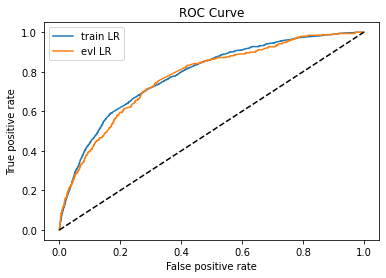

In [45]:
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

* preA模型


train_ks :  0.3221610793015221
val_ks :  0.30984257092842543


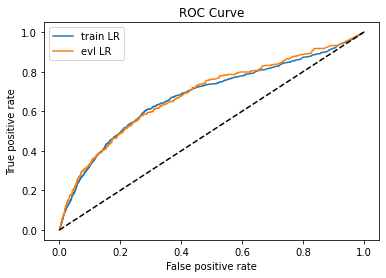

In [46]:
#clf就是IF的对象，它是一个无监督的模型，因此效果不是特别理想
y_pred = clf.predict_proba(x,method ='linear')[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = clf.predict_proba(val_x,method ='linear')[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()


In [47]:
import math
#准备数据
model = clf
bins = 20
temp_ = pd.DataFrame() #创建空白DataFrame
temp_['bad_rate_predict'] = [s[1] for s in model.predict_proba(val_x)]# 预测结果（坏人概率）
temp_['real_bad'] = val_y # 真实结果
temp_ = temp_.sort_values('bad_rate_predict',ascending = False)#按照预测坏人概率降序排列
temp_['num'] = [i for i in range(temp_.shape[0])] #添加序号列，用于分组
temp_['num'] = pd.cut(temp_.num,bins = bins,labels = [i for i in range(bins)])#分成20组，为每组添加组号

#创建报告
report = pd.DataFrame()#创建空白DataFrame
#计算每一组坏人数量
report['BAD'] = temp_.groupby('num').real_bad.sum().astype(int)
#计算每一组好人数量
report['GOOD'] = temp_.groupby('num').real_bad.count().astype(int)-report['BAD']
#累计求和坏人数量
report['BAD_CNT'] = report['BAD'].cumsum()
#累计求和好人数量
report['GOOD_CNT'] = report['GOOD'].cumsum()
good_total = report.GOOD_CNT.max()
bad_total = report.BAD_CNT.max()
#计算到当前组坏人比例（占所有坏人比例）
report['BAD_PCTG'] = round(report.BAD_CNT/bad_total,3)
#计算当前组坏人概率
report['BADRATE'] =report.apply(lambda x: round(x.BAD/(x.BAD+x.GOOD),3),axis = 1)
#计算KS值
def cal_ks(x):
  #当前箱累计坏人数量/总坏人数量  - 当前箱累计好人数量/好人数量
    ks = (x.BAD_CNT/bad_total)-(x.GOOD_CNT/good_total)
    return round(math.fabs(ks),3)
report['KS'] = report.apply(cal_ks,axis = 1)
report


,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE,KS
num,,,,,,,
0,68,731,68,731,0.207,0.085,0.161
1,38,761,106,1492,0.323,0.048,0.228
2,27,772,133,2264,0.405,0.034,0.261
3,25,773,158,3037,0.482,0.031,0.288
4,21,778,179,3815,0.546,0.026,0.302
5,16,783,195,4598,0.595,0.020,0.301
6,13,785,208,5383,0.634,0.016,0.290
7,13,786,221,6169,0.674,0.016,0.280
8,15,784,236,6953,0.720,0.019,0.275
